<a href="https://colab.research.google.com/github/siposroland/cvs_hw_3d/blob/master/CV_HW_TASK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# installing Requirements
!pip install torch torchvision

# Download dataset

In [0]:
# Homework dataset
!wget http://deeplearning.iit.bme.hu/CVS/HW.zip
!unzip -qq HW.zip
!rm HW.zip

# Traffic Sign Classification set
!wget http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
!unzip -qq trafficSignsHW.zip
!rm trafficSignsHW.zip

--2020-05-23 11:02:45--  http://deeplearning.iit.bme.hu/CVS/HW.zip
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14446460 (14M) [application/zip]
Saving to: ‘HW.zip’

HW.zip              100%[===================>]  13.78M  9.43MB/s    in 1.5s    

2020-05-23 11:02:50 (9.43 MB/s) - ‘HW.zip’ saved [14446460/14446460]

--2020-05-23 11:02:53--  http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175675617 (168M) [application/zip]
Saving to: ‘trafficSignsHW.zip’

trafficSignsHW.zip  100%[===================>] 167.54M  19.1MB/s    in 9.5s    

2020-05-23 11:03:07 (17.7 MB/s) - ‘traff

Class names


In [0]:
classNames = ['traffic sign', 'vehicle', 'cactus']
subclassNames = [
    ['Bump', 'Bumpy road', 'Bus stop', 'Children', 'Crossing (blue)', 'Crossing (red)', 'Cyclists',
     'Danger (other)', 'Dangerous left turn', 'Dangerous right turn', 'Give way', 'Go ahead', 'Go ahead or left',
     'Go ahead or right', 'Go around either way', 'Go around left', 'Go around right', 'Intersection', 'Limit 100',
     'Limit 120', 'Limit 20', 'Limit 30', 'Limit 50', 'Limit 60', 'Limit 70', 'Limit 80', 'Limit 80 over',
     'Limit over', 'Main road', 'Main road over', 'Multiple dangerous turns', 'Narrow road (left)',
     'Narrow road (right)', 'No entry', 'No entry (both directions)', 'No entry (truck)', 'No stopping', 'No takeover',
     'No takeover (truck)', 'No takeover (truck) end', 'No takeover end', 'No waiting', 'One way road',
     'Parking', 'Road works', 'Roundabout', 'Slippery road', 'Stop', 'Traffic light', 'Train crossing',
     'Train crossing (no barrier)', 'Wild animals', 'X - Priority', 'X - Turn left', 'X - Turn right'],
    ['SUV','truck','plane'],
    ['happy','sad','angry','evil']
]

# Your Work

In [0]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch import optim

# Convolutional module (Conv+ReLU+BatchNorm)
class Conv(nn.Module):
  def __init__(self, in_channels, channels,kernel_size=3, stride=1):   #kernel_size=3
     super(Conv, self).__init__()
     self.conv = nn.Conv2d(in_channels, channels, kernel_size, stride=stride, padding=kernel_size//2, bias=False)   #padding=1
     self.bn = nn.BatchNorm2d(channels)
  def forward(self,x):
     return self.bn(torch.relu(self.conv(x)))
  

class ConvNet(nn.Module):
  def __init__(self, base_channels=16, in_channels=3, num_classes=55):  #in_channels=4
      super(ConvNet, self).__init__()   
      
      self.c11 = Conv(in_channels, base_channels)
      self.c12 = Conv(base_channels, base_channels)
      # Downscale using strided convolution and expand channels
      self.d1 = Conv(base_channels, base_channels*2, stride=2)

      self.c21 = Conv(base_channels*2, base_channels*2)
      self.c22 = Conv(base_channels*2, base_channels*2)
      self.d2 = Conv(base_channels*2, base_channels*4, stride=2)
        
      self.c31 = Conv(base_channels*4, base_channels*4)
      self.c32 = Conv(base_channels*4, base_channels*4)
      self.d3 = Conv(base_channels*4, base_channels*8, stride=2)
        
      self.c41 = Conv(base_channels*8, base_channels*8)
      self.c42 = Conv(base_channels*8, base_channels*8)
      self.d4 = Conv(base_channels*8, base_channels*16, stride=2)
        
      self.c51 = Conv(base_channels*16, base_channels*16)
      self.c52 = Conv(base_channels*16, base_channels*16)
      self.d5 = Conv(base_channels*16, base_channels*32, stride=2)
      # Input image is 32x32 -> after 5 downscaling the activation map is 1x1
      
      # Classifier is a convolution that produces num_classes class scores
      self.classifier = nn.Conv2d(base_channels*32,num_classes, 1) #kernel_size=1

  def forward(self,x):
        # Class all the layers
        x = self.d1(self.c12(self.c11(x)))
        x = self.d2(self.c22(self.c21(x)))
        x = self.d3(self.c32(self.c31(x)))
        x = self.d4(self.c42(self.c41(x)))
        x = self.d5(self.c52(self.c51(x)))
        return torch.squeeze(self.classifier(x))


haveCuda = torch.cuda.is_available()

#DATA AUGMENTATION
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
     #transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)) # mean = 0 and standard-deviation = 1
])

transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    # Random perturbance of brightness, contrast and color
    transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.3,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
    #transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)) # mean = 0 and standard-deviation = 1
])

#DATASETS
trainSet = torchvision.datasets.ImageFolder(root="./trafficSignsHW/trainFULL", transform=transform)
testSet = torchvision.datasets.ImageFolder(root="./trafficSignsHW/testFULL", transform=transform_val) #is_valid_file=None
#valSet= torchvision.datasets.ImageFolder(root="./trafficSignsHW/trainFULL", transform=transform_val)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=512, shuffle=True) #sampler overfitting kevés adatra bs=128
testLoader = torch.utils.data.DataLoader(testSet, batch_size=512, shuffle=False)
#valLoader= torch.utils.data.DataLoader(valSet, batch_size=512, shuffle=False)

def createNet():
    net = ConvNet()  #neurális háló létrehozása base_chanels=(16)
    if haveCuda:
        net = net.cuda()
    return net

def createLoss():
    return nn.CrossEntropyLoss()

# create optimizer
def createOptimizer():
    return optim.SGD(net.parameters(), lr=1e-2, momentum=0.5)  # lr=1e-1, momentum=0.9,nesterov=True, weight_decay=1e-4

numEpoch =10

def createScheduler():
    return optim.lr_scheduler.CosineAnnealingLR(optimizer,numEpoch,eta_min=1e-2)


#Progress bar
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))



def train(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to train (for batchnorm and dropout)
    net.train()

    # Create progress bar
    bar = display(progress(0, len(trainLoader)), display_id=True)

    for i, data in enumerate(trainLoader, 0):
        
        inputs, labels = data
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        # Forward
        outputs = net(inputs)
        # Loss
        loss = criterion(outputs, labels)  #loss = torch.nn.functional.nll_loss(outputs, labels)
        # Backpropagation
        loss.backward()
        # Gradient method
        optimizer.step()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Accumulate loss
            running_loss += loss.item()
            # Get indices of the largest goodness values
            _, predicted = torch.max(outputs, 1)
            # Count how many of the predictions equal the labels
            correct += predicted.eq(labels).sum().item()
            # Accumulate number of total images seen
            total += labels.shape[0]   ####

        # Progress bar
        bar.update(progress(i+1, len(trainLoader)))

    # return loss and accuracy
    tr_loss = running_loss / i
    tr_corr = correct / total * 100
    print("Train epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, tr_corr))
    return tr_loss,tr_corr

# Function for validating a single epch
def val(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to eval  (for batchnorm and dropout)
    net.eval()

    # Create progress bar
    bar = display(progress(0, len(testLoader)), display_id=True)

    for i, data in enumerate(testLoader, 0):
        # get the inputs
        inputs, labels = data
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Forward
            outputs = net(inputs)
            # Compute loss
            loss = criterion(outputs, labels)

            # Compute statistics, just like before
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(labels).sum().item()
            total += labels.shape[0]

        bar.update(progress(i+1, len(testLoader)))

    # return loss and accuracy
    val_loss = running_loss / i
    val_corr = correct / total * 100
    print("Test epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, val_corr))
    return val_loss,val_corr

#MAIN LOOP
# Containers for losses and accuracies for every epoch
train_accs = []
train_losses = []
val_accs = []
val_losses = []

# Best validation accuracy
best_acc = 0

# Set pseudo-random generator seeds to make multiple runs comparable
torch.manual_seed(42)
if haveCuda:
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic= True
    torch.backends.cudnn.benchmark= False
# Create net, criterion, optimizer and scheduler
# This needs to be done after setting the random seed, 
# so that the random initialization would be the same
net = createNet()
criterion = createLoss()
optimizer = createOptimizer()
scheduler = createScheduler()

# For numEpoch epochs
for epoch in range(numEpoch): 
    
    # Train
    loss,acc = train(epoch)
    train_accs.append(acc)
    train_losses.append(loss)
    
    # Validate
    loss,acc = val(epoch)
    val_accs.append(acc)
    val_losses.append(loss)
    
    # Step with the LR scheduler
    scheduler.step()
    
    # If the current model is better, than the previous best, save it
    if acc > best_acc:
        print("Best Model, Saving")
        best_acc = acc
        torch.save(net,"./model.pth")

Train epoch 1 loss: 2.060 correct: 44.60


Test epoch 1 loss: 0.872 correct: 74.71
Best Model, Saving


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train epoch 2 loss: 0.507 correct: 85.73


Test epoch 2 loss: 0.367 correct: 89.69
Best Model, Saving


Train epoch 3 loss: 0.227 correct: 93.85


Test epoch 3 loss: 0.349 correct: 92.05
Best Model, Saving


Train epoch 4 loss: 0.138 correct: 96.37


Test epoch 4 loss: 0.105 correct: 97.17
Best Model, Saving


Train epoch 5 loss: 0.101 correct: 97.30


Test epoch 5 loss: 0.080 correct: 98.11
Best Model, Saving


Train epoch 6 loss: 0.082 correct: 97.78


Test epoch 6 loss: 0.064 correct: 98.38
Best Model, Saving


Train epoch 7 loss: 0.068 correct: 98.16


Test epoch 7 loss: 0.097 correct: 97.50


Train epoch 8 loss: 0.059 correct: 98.41


Test epoch 8 loss: 0.056 correct: 98.74
Best Model, Saving


Train epoch 9 loss: 0.052 correct: 98.61


Test epoch 9 loss: 0.116 correct: 97.20


Train epoch 10 loss: 0.047 correct: 98.72


Test epoch 10 loss: 0.047 correct: 98.86
Best Model, Saving


# Plot graphs

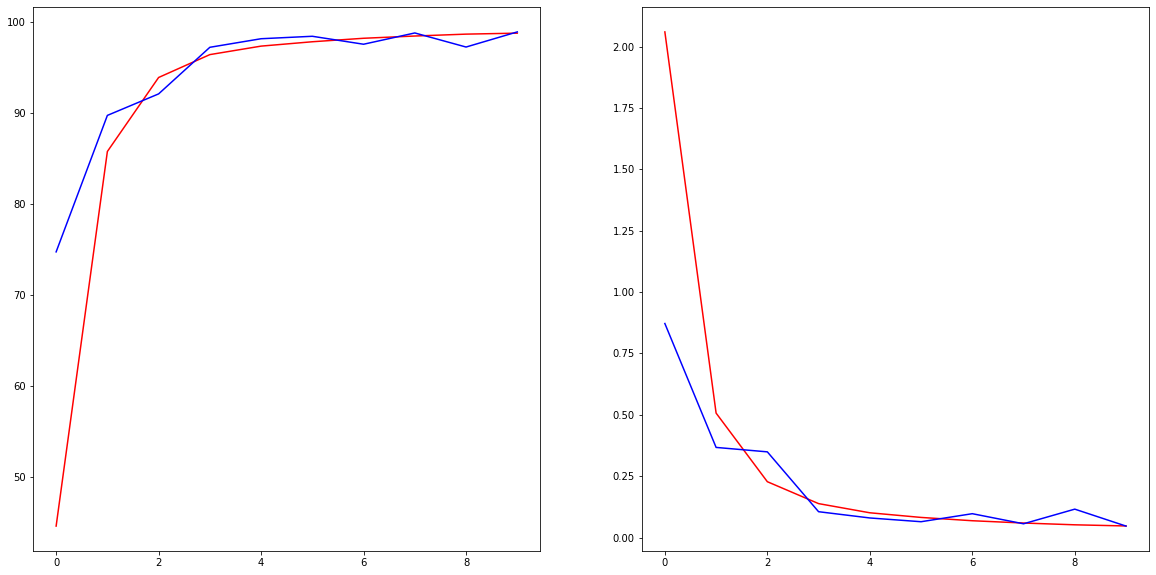

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# X coordinate for plotting
x = np.arange(numEpoch)

plt.figure(figsize=(20,10))

# Train is red, validation is blue
plt.subplot(1,2,1)
plt.plot(x,train_accs,'r')
plt.plot(x,val_accs,'b')

plt.subplot(1,2,2)
plt.plot(x,train_losses,'r')
plt.plot(x,val_losses,'b')

plt.show()




# Load model and classify image

In [11]:
from PIL import Image

model = torch.load("./model.pth")
model.eval()

transform = transforms.Compose([transforms.ToTensor()]) 

img = Image.open("/content/img(7776).jpg")  
x = transform(img)  # Preprocess image
x = x.unsqueeze(0)  # Add batch dimension
x=x.cuda()

output = model(x)  # Forward pass
_, pred = torch.max(output, 0)  # Get predicted class if multi-class classification

print('Image predicted as ', subclassNames[0][pred.item()])
print(torch.max(output,0))


Image predicted as  No waiting
torch.return_types.max(
values=tensor(7.5168, device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor(41, device='cuda:0'))
